# Import libraries

In [1]:
# Data manipulation 
import pandas as pd

# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta

# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt

# Technical indicators
from ta.momentum import rsi, stochrsi_d,stochrsi_k, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Filtering
from scipy.signal import savgol_filter

# Kucoin
from kucoin.client import Market
client = Market(url='https://api.kucoin.com')

Loading BokehJS ...

# Utils

In [25]:

def computeSuperTrend(df:pd.DataFrame,upper=False, lower=False)->pd.DataFrame:
    """Compute the super trend indicator for a dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: The resulting dataframe with 3 new columns
    """
    class SuperTrend():
        def __init__(
            self,
            High,
            Low,
            Close,
            atr_window=10,
            atr_multi=3
        ):
            self.High = High
            self.Low = Low
            self.Close = Close
            self.atr_window = atr_window
            self.atr_multi = atr_multi
            self._run()
            
        def _run(self):
            # calculate ATR
            price_diffs = [self.High - self.Low, 
                        self.High - self.Close.shift(), 
                        self.Close.shift() - self.Low]
            true_range = pd.concat(price_diffs, axis=1)
            true_range = true_range.abs().max(axis=1)
            # default ATR calculation in supertrend indicator
            atr = true_range.ewm(alpha=1/self.atr_window,min_periods=self.atr_window).mean() 
            # atr = ta.volatility.average_true_range(High, Low, Close, atr_period)
            # df['atr'] = df['tr'].rolling(atr_period).mean()
            
            # HL2 is simply the average of High and Low prices
            hl2 = (self.High + self.Low) / 2
            # upperband and lowerband calculation
            # notice that final bands are set to be equal to the respective bands
            final_upperband = upperband = hl2 + (self.atr_multi * atr)
            final_lowerband = lowerband = hl2 - (self.atr_multi * atr)
            
            # initialize Supertrend column to True
            supertrend = [True] * len(self.Close)
            
            for i in range(1, len(self.Close)):
                curr, prev = i, i-1
                
                # if current Close price crosses above upperband
                if self.Close[curr] > final_upperband[prev]:
                    supertrend[curr] = True
                # if current Close price crosses below lowerband
                elif self.Close[curr] < final_lowerband[prev]:
                    supertrend[curr] = False
                # else, the trend continues
                else:
                    supertrend[curr] = supertrend[prev]
                    
                    # adjustment to the final bands
                    if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                        final_lowerband[curr] = final_lowerband[prev]
                    if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                        final_upperband[curr] = final_upperband[prev]

                # to remove bands according to the trend direction
                if supertrend[curr] == True:
                    final_upperband[curr] = np.nan
                else:
                    final_lowerband[curr] = np.nan
                    
            self.st = pd.DataFrame({
                'Supertrend': supertrend,
                'Final Lowerband': final_lowerband,
                'Final Upperband': final_upperband
            })
            
        def superTrendUpper(self):
            return self.st['Final Upperband']
            
        def superTrendLower(self):
            return self.st['Final Lowerband']
            
        def superTrendDirection(self):
            return self.st['Supertrend']
        
    st = SuperTrend(df.High, df.Low, df.Close)
    
    if upper==True:
        df['ST_Upper']  = st.superTrendUpper()
    if lower==True:
        df['ST_Lower'] = st.superTrendLower()
    df['ST_Direction'] = st.superTrendDirection()
    return df

def addIndicators(df:pd.DataFrame,b_engulfings:bool=False, derivative:bool=False, double_derivative:bool=False) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    def isBearishCandleStick(candle) -> bool:
        """Check whether a candle is a bearish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bearish candle (True) or not (False)
        """
        return candle['Close']<candle['Open']

    def isBullishCandleStick(candle) -> bool:
        """Check whether a candle is a bullish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bullish candle (True) or not (False)
        """
        return candle['Close']>candle['Open']

    def isBullishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bullish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bullish engulfing, 0 not.
        """
        return 1 if isBearishCandleStick(previous_candle) and isBullishCandleStick(current_candle) and previous_candle['Open']<current_candle['Close'] and previous_candle['Close']>current_candle['Open'] else 0
        
    def isBearishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bearish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bearish engulfing, 0 not.
        """
        return 1 if isBullishCandleStick(previous_candle) and isBearishCandleStick(current_candle) and previous_candle['Close']<current_candle['Open'] and previous_candle['Open']>current_candle['Close'] else 0    
            
    #df['RSI'] = rsi(df.Close,14,fillna=True)
    df['EMA20'] = ema_indicator(df.Close,20)
    df['EMA50'] = ema_indicator(df.Close,50)
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['MACD'] = macd_diff(df.Close)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['Vortex'] = (vortex_indicator_pos(df.High,df.Low,df.Close,20,fillna=True)-1)-(vortex_indicator_neg(df.High,df.Low,df.Close,20,fillna=True)-1)
    df['Bollinger_low'] = bollinger_hband(df.Close,20,fillna=True)
    df['Bollinger_high'] = bollinger_lband(df.Close,20,fillna=True)
    df['ADX'] = adx(df.High,df.Low,df.Close)
    df['CCI'] = cci(df.High,df.Low,df.Close,14)
    trixLength = 9
    trixSignal = 21
    df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
    df['TRIX_PCT'] = df["TRIX"].pct_change()*100
    df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
    df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
    #df['EVM'] = ease_of_movement(df.High,df.Low,df.Volume,14)
    if b_engulfings==True:
        df['Bullish_engulfing'] = np.nan
        df['Bullish_engulfing'].iloc[1:] = [isBullishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
        df['Bearish_engulfing'] = np.nan
        df['Bearish_engulfing'].iloc[1:] = [isBearishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
    if derivative==True:
        df['Slope'] = df.Close.diff()
    if double_derivative==True:
        df['Acceleration'] = df.Close.diff().diff()
    return computeSuperTrend(df).dropna()


def addTrixIndicators(df, trix_length=9,trix_signal=21,rsi_window=14)->pd.DataFrame:
    trix = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trix_length), window=trix_length), window=trix_length)
    trix_pct = trix.pct_change()*100
    trix_sig = sma_indicator(trix_pct,trix_signal)
    df['TRIX_HISTO'] = trix_pct - trix_sig
    df['Stoch_RSI'] = stochrsi(df.Close, rsi_window, smooth1=3, smooth2=3)
    return df

In [15]:
klines = client.get_kline('ETH-USDT','1hour', startAt=round(datetime.now().timestamp())-94900000, endAt=round(datetime.now().timestamp()))

df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Volume','Amount'],dtype=float)
df = df.sort_values(by='Date')
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
print(len(df))
addIndicators(df)
df.head()

1500


,Open,High,Low,Close,Volume,Amount,Timestamp,EMA20,EMA50,EMA100,...,Vortex,Bollinger_low,Bollinger_high,ADX,CCI,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,ST_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-12 11:00:00,3025.31,3025.72,3029.04,3012.98,2071.516910,6.256231e+06,1649754000,NaN,NaN,NaN,...,0.000000,3012.980000,3012.980000,0.0,NaN,NaN,NaN,NaN,NaN,True
2022-04-12 12:00:00,3025.21,3016.79,3028.40,3012.00,1660.849504,5.016696e+06,1649757600,NaN,NaN,NaN,...,0.013289,3013.470000,3011.510000,0.0,NaN,NaN,NaN,NaN,NaN,True
2022-04-12 13:00:00,3016.94,3040.86,3042.30,3013.47,3020.966994,9.160056e+06,1649761200,NaN,NaN,NaN,...,-0.004637,3014.038941,3011.594392,0.0,NaN,NaN,NaN,NaN,NaN,True
2022-04-12 14:00:00,3040.86,3079.29,3081.09,3025.17,6489.949811,1.981985e+07,1649764800,NaN,NaN,NaN,...,-0.008214,3026.655540,3005.154460,0.0,NaN,NaN,NaN,NaN,NaN,True
2022-04-12 15:00:00,3079.28,3051.04,3085.13,3048.01,6237.867539,1.911897e+07,1649768400,NaN,NaN,NaN,...,0.019920,3049.750936,2994.901064,0.0,NaN,NaN,NaN,NaN,NaN,True


In [3]:
df = pd.read_csv('../backtest_tools/database/database/Binance/1h/BTC-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA50,EMA100,EMA200,...,Vortex,Bollinger_low,Bollinger_high,ADX,CCI,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,ST_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-25 13:00:00,4331.67,4361.28,4313.00,4361.27,25.795114,1503658800,4292.605335,4217.466645,4161.133596,4156.523435,...,0.217861,4410.448160,4172.920840,26.097672,79.361191,4278.538219,0.148407,0.150313,-0.001906,True
2017-08-25 14:00:00,4361.27,4361.27,4261.13,4309.69,110.998609,1503662400,4294.232446,4221.083247,4164.075307,4158.047480,...,0.148735,4410.014255,4182.823745,24.788873,-87.550987,4284.351944,0.135881,0.153203,-0.017322,True
2017-08-25 15:00:00,4311.69,4345.00,4297.66,4312.00,20.801018,1503666000,4295.924594,4224.648610,4167.004509,4159.579346,...,0.209376,4404.864512,4200.355488,23.573560,-45.058908,4289.512651,0.120455,0.154794,-0.034340,True
2017-08-25 16:00:00,4303.82,4340.00,4291.52,4305.00,10.610266,1503669600,4296.788919,4227.799645,4169.737093,4161.026318,...,0.210704,4401.965291,4211.654709,22.603972,-64.759345,4293.926198,0.102892,0.155366,-0.052474,True
2017-08-25 17:00:00,4321.50,4422.29,4321.50,4394.36,21.796763,1503673200,4306.081402,4234.331424,4174.185071,4163.348046,...,0.244611,4408.584109,4222.864891,22.304347,209.585356,4298.301661,0.101899,0.155654,-0.053755,True


In [4]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if ((df['TRIX_HISTO'][i] >= 0 and df['Stoch_RSI'][i] < 0.8 ) and df['Close'][i]>df['EMA200'][i] ) or (df['TRIX_HISTO'][i] < 0 and df['Stoch_RSI'][i] < 0.2) :#and df['ST_Direction'][i]==True :
            df['BUY_SELL'][i] = 'BUY'
            POSITION_OPENED=True   
            last_buy_price  = df['Close'][i]       
    else:
        if df['TRIX_HISTO'][i] < 0 and df['Stoch_RSI'][i] > 0.2:
            df['BUY_SELL'][i] = 'SELL'
            POSITION_OPENED=False   
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Change'] = trades['Close'].pct_change()*100
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum())} %")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)*2}")
print(f"Average pct {trades.Change.mean()}%")
print(f"Average gain {trades[trades['Change']>0].Change.mean()}%")
print(f"Average loss {trades[trades['Change']<0].Change.mean()}%")
print(f"Total not worthy trade {trades[trades['Change']<0.1]['Change'].count()}")

equity = 1000
for i in range(len(trades)):
    equity = equity*(1+trades.iloc[i].Change/100)
        
print(equity)


Gain : 572 %
Winrate : 66 %
Total trades : 5520
Average pct 0.20736292132026515%
Average gain 1.054813084489151%
Average loss -1.4229013756232698%
Total not worthy trade 1085
155507.49333332485


# Trix Optimisation

In [22]:
trix_signals

[18, 19, 20, 21, 22, 23]

In [26]:
results = []
trix_signals = [round(i) for i in np.linspace(18,23,6)]
trix_length =[round(i) for i in np.linspace(7,15,5)]
rsi_length = [11,14,17,20,25]

oversold = [0.76, 0.78,0.80,0.82,0.84]

overbought= [0.16, 0.18,0.20,0.22,0.24]

for ts in trix_signals:
    for tl in trix_length:
        for rl in rsi_length:
            for ob in overbought:
                for oss in oversold:
                    
                    df = pd.read_csv('../backtest_tools/database/database/Binance/1h/AVAX-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
                    df = df.iloc[1:]
                    df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
                    df = df.astype(float)
                    #df['Timestamp'] = df['Date'].astype(int)
                    df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
                    df = df.set_index('Date')
                    df = addTrixIndicators(df,tl,ts,rl)

                    POSITION_OPENED = False
                    df['BUY_SELL'] = 'HOLD'
                    for i in range(1,len(df)):
                        if POSITION_OPENED==False:
                            if (df['TRIX_HISTO'][i] >= 0 and df['Stoch_RSI'][i] < oss ) :#and df['Close'][i]>df['EMA200'][i] ) or (df['TRIX_HISTO'][i] < 0 and df['Stoch_RSI'][i] < 0.2) :#and df['ST_Direction'][i]==True :
                                df['BUY_SELL'][i] = 'BUY'
                                POSITION_OPENED=True   
                                last_buy_price  = df['Close'][i]       
                        else:
                            if df['TRIX_HISTO'][i] < 0 and df['Stoch_RSI'][i] > ob:
                                df['BUY_SELL'][i] = 'SELL'
                                POSITION_OPENED=False   
                                
                    trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
                    trades['Change'] = trades['Close'].pct_change()
                    trades = trades[trades['BUY_SELL']=='SELL']
                    equity = 1000
                    for i in range(len(trades)):
                        equity = equity*(1+trades.iloc[i].Change)
                            
                    print(equity)
                    results.append({
                        'equity':equity,
                        'RSI':rl,
                        'Trix_length':tl,
                        'Trix_sig':ts,
                        'Over_b':ob,
                        'Over_s':oss
                    })
    


23570.226305972035
28913.500110393994
29805.158176910074
24763.878521397244
20909.464558014628
25660.24912884203
31477.32255042138
32448.04586158224
26959.745061693702
22763.551895698263
21492.380175045095
26364.614768520274
27177.668232790686
22580.805329631075
19066.179327417714
26869.71309578924
32960.96704699483
33977.4441955729
28230.459155172714
23836.48363690398
24964.876379115198
30624.311645265378
31568.72911135362
26229.156985118443
22146.677383070568
18901.74102791469
25184.165379224072
22506.608308456318
26130.921244572393
23427.372864206733
20517.804214804706
27337.36399208245
24430.880844797433
28365.065697218768
25430.369032415685
20770.898410036873
27674.57981044729
24732.244190577163
28714.958570753744
25744.061409891103
16144.419089224955
21510.38466213709
19223.420544813023
22319.03098962574
20009.86708688487
16357.769380869298
21794.646784898185
19477.46018271948
22613.979463431897
20274.29970320607
13647.409854201074
12366.823798862131
11414.415868206455
10167.7348

KeyboardInterrupt: 

In [27]:
results

[{'equity': 23570.226305972035,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.16,
  'Over_s': 0.76},
 {'equity': 28913.500110393994,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.16,
  'Over_s': 0.78},
 {'equity': 29805.158176910074,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.16,
  'Over_s': 0.8},
 {'equity': 24763.878521397244,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.16,
  'Over_s': 0.82},
 {'equity': 20909.464558014628,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.16,
  'Over_s': 0.84},
 {'equity': 25660.24912884203,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.18,
  'Over_s': 0.76},
 {'equity': 31477.32255042138,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.18,
  'Over_s': 0.78},
 {'equity': 32448.04586158224,
  'RSI': 11,
  'Trix_length': 7,
  'Trix_sig': 18,
  'Over_b': 0.18,
  'Over_s': 0.8},
 {'equity': 26959.745061693702,
  'RSI': 11,


In [28]:
df_result = pd.DataFrame(results)
df_result

,equity,RSI,Trix_length,Trix_sig,Over_b,Over_s
0,23570.226306,11,7,18,0.16,0.76
1,28913.500110,11,7,18,0.16,0.78
2,29805.158177,11,7,18,0.16,0.80
3,24763.878521,11,7,18,0.16,0.82
4,20909.464558,11,7,18,0.16,0.84
...,...,...,...,...,...,...
3367,19673.948430,25,9,23,0.22,0.80
3368,21244.620747,25,9,23,0.22,0.82
3369,28394.805038,25,9,23,0.22,0.84
3370,18017.780320,25,9,23,0.24,0.76


In [31]:
df_result.equity.idxmax()

930

In [32]:
df_result.iloc[930]

equity         59584.42784
RSI               17.00000
Trix_length       11.00000
Trix_sig          19.00000
Over_b             0.18000
Over_s             0.76000
Name: 930, dtype: float64

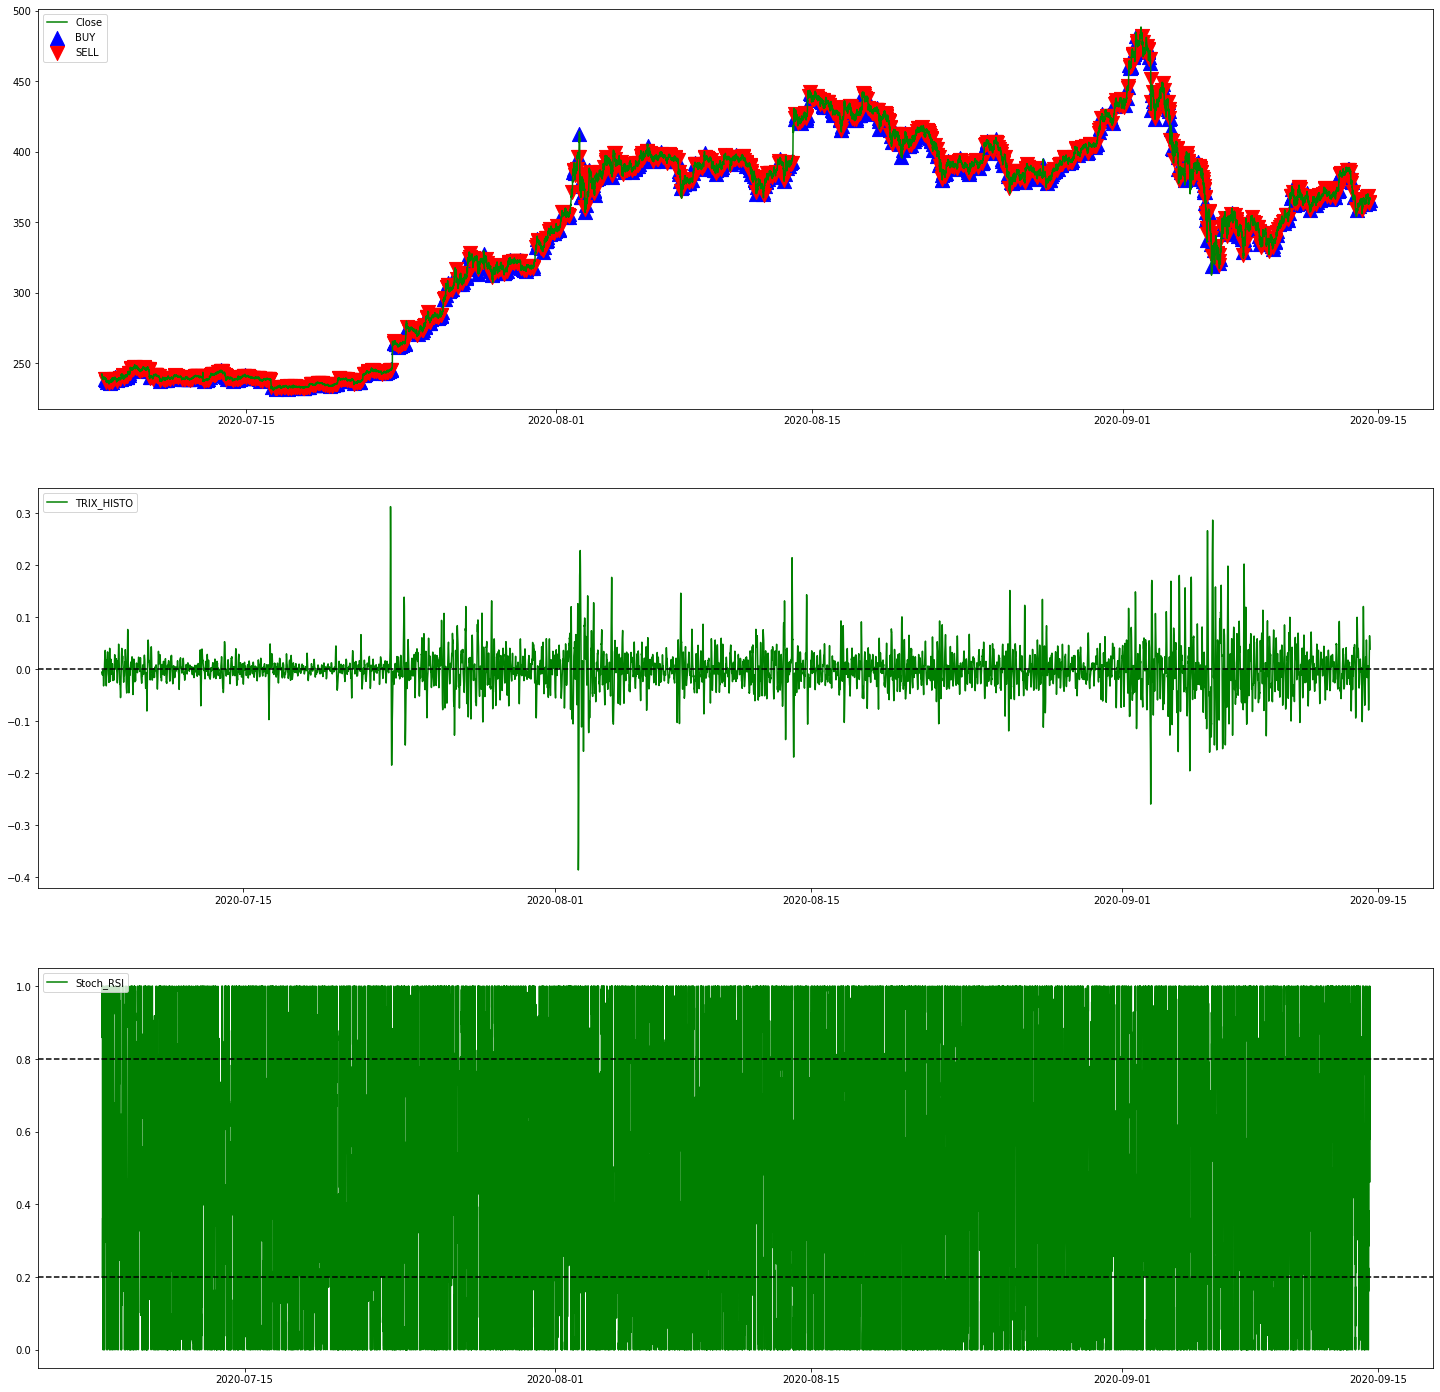

In [67]:
fig, ax_left = plt.subplots(3, figsize=(25,25))

ax_left[0].plot(df.Close, color='green',label='Close')
ax_left[0].scatter(df[df['BUY_SELL']=='BUY'].index, df[df['BUY_SELL']=='BUY'].Close, color='blue',label='BUY',marker='^',s=200)
ax_left[0].scatter(df[df['BUY_SELL']=='SELL'].index, df[df['BUY_SELL']=='SELL'].Close, color='red',label='SELL',marker='v',s=200)
ax_left[0].legend(loc="upper left")

ax_left[1].plot(df.TRIX_HISTO, color='green',label='TRIX_HISTO')
ax_left[1].axhline(y=0, color='black', linestyle='--')
ax_left[1].legend(loc="upper left")

ax_left[2].plot(df.Stoch_RSI, color='green',label='Stoch_RSI')
ax_left[2].axhline(y=0.2, color='black', linestyle='--')
ax_left[2].axhline(y=0.8, color='black', linestyle='--')
ax_left[2].legend(loc="upper left")

# Trix strategy on Forex

In [68]:
def addTimestampToDf(df)->pd.DataFrame:
    """add timestamp to dataframe as column

    Args:
        df (pd.DataFrame): The Dataframe we want to add timestamp as col

    Returns:
        pd.DataFrame: The Dataframe with the new column
    """
    df['timestamp'] = [round(datetime.timestamp(df.index[ind])) for ind in range(len(df.index))]
    df['timestamp'] = df['timestamp'].astype(int)
    
    
import yfinance as yf  

In [113]:
def getForexData(symbol='EURUSD=X',intraday=True, interval='1m')->pd.DataFrame:
    """Get symbol data from yFinance.

    Args:
        symbol (str, optional): The Symbol you want. Defaults to 'AMZN'.
        interval (str, optional): The interval to construct candlesticks : 1h, 15m, 1m... Defaults to '15m'.

    Returns:
        pd.DataFrame: The Dataframe containing all the data and the features.
    """
    if intraday==True:
        if interval=='1m':
            n=7
        else:
            n = 59
        current_date = datetime.today()
        past_date = current_date - relativedelta(days=n)
        return yf.Ticker(f"{symbol}").history(interval=interval,start=past_date,end=current_date,tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])
        return addIndicators(addTimestampToDf(yf.Ticker(f"{symbol}").history(interval=interval,start=past_date,end=current_date,tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])  ))
    else:
        return addIndicators(addTimestampToDf(yf.Ticker(f"{symbol}").history(period='max',interval='1d',tzinfo=pytz.utc).drop(columns=['Dividends','Stock Splits'])))

In [120]:
df = pd.read_csv('./data/EURUSD30.csv',sep='\t',names=['Date','Open','High','Low','Close','Volume'])
df = df.set_index('Date')
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,RSI,EMA20,EMA50,EMA100,EMA200,...,Slope,Acceleration,Bullish_engulfing,Bearish_engulfing,ADX,CCI,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-03 01:30,1.36021,1.36037,1.36018,1.36027,987,51.039181,1.360102,1.360619,1.361028,1.361428,...,0.00008,0.00009,0.0,0.0,15.850330,105.017387,1.359959,0.000165,-0.004510,0.004675
2014-06-03 02:00,1.36027,1.36042,1.36023,1.36042,1255,53.730693,1.360132,1.360611,1.361016,1.361418,...,0.00015,0.00007,0.0,0.0,15.029844,104.694459,1.359968,0.000686,-0.004215,0.004901
2014-06-03 02:30,1.36042,1.36043,1.36026,1.36030,1874,51.301017,1.360148,1.360599,1.361002,1.361407,...,-0.00012,-0.00027,0.0,0.0,14.234242,83.379079,1.359983,0.001077,-0.003860,0.004937
2014-06-03 03:00,1.36031,1.36044,1.36024,1.36039,494,53.016999,1.360171,1.360591,1.360990,1.361397,...,0.00009,0.00021,0.0,0.0,13.561710,79.110642,1.360002,0.001405,-0.003474,0.004878
2014-06-03 03:30,1.36039,1.36049,1.36030,1.36041,3699,53.409877,1.360194,1.360584,1.360979,1.361387,...,0.00002,-0.00007,0.0,0.0,12.747636,80.959453,1.360024,0.001666,-0.003070,0.004737


In [121]:
POSITION_OPENED = False
df['BUY_SELL'] = 'HOLD'
risk = 0.005
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if (df['TRIX_HISTO'][i] > 0 and df['Stoch_RSI'][i] < 0.8 ) or (df['TRIX_HISTO'][i] < 0 and df['Stoch_RSI'][i] < 0.2 ):
            df['BUY_SELL'][i] = 'BUY'
            POSITION_OPENED=True   
            last_buy_price  = df['Close'][i]       
    else:
        if df['TRIX_HISTO'][i] < 0 and df['Stoch_RSI'][i] > 0.2:
            df['BUY_SELL'][i] = 'SELL'
            POSITION_OPENED=False   
        elif df['Close'][i]<=last_buy_price*1-risk:
            df['BUY_SELL'][i] = 'SELL'
            POSITION_OPENED=False   
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Change'] = np.nan
trades['Change'].iloc[1:]= [(trades.Close.iloc[i]-trades.Close.iloc[i-1])*10**4 for i in range(1,len(trades.Close))]
trades = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades.Change.sum()*0.9)} €")
print(f"Winrate : {round(100*len(trades[trades['Change']>0].Change)/len(trades))} %")
print(f"Total trades : {len(trades)*2}")
print(f"Average pct {trades.Change.mean()} %")
print(f"Average gain {trades[trades['Change']>0].Change.mean()} %")
print(f"Average loss {trades[trades['Change']<0].Change.mean()} %")

Gain : 260 €
Winrate : 58 %
Total trades : 13952
Average pct 0.041456422018353485 %
Average gain 12.164774417451667 %
Average loss -16.758330470628646 %


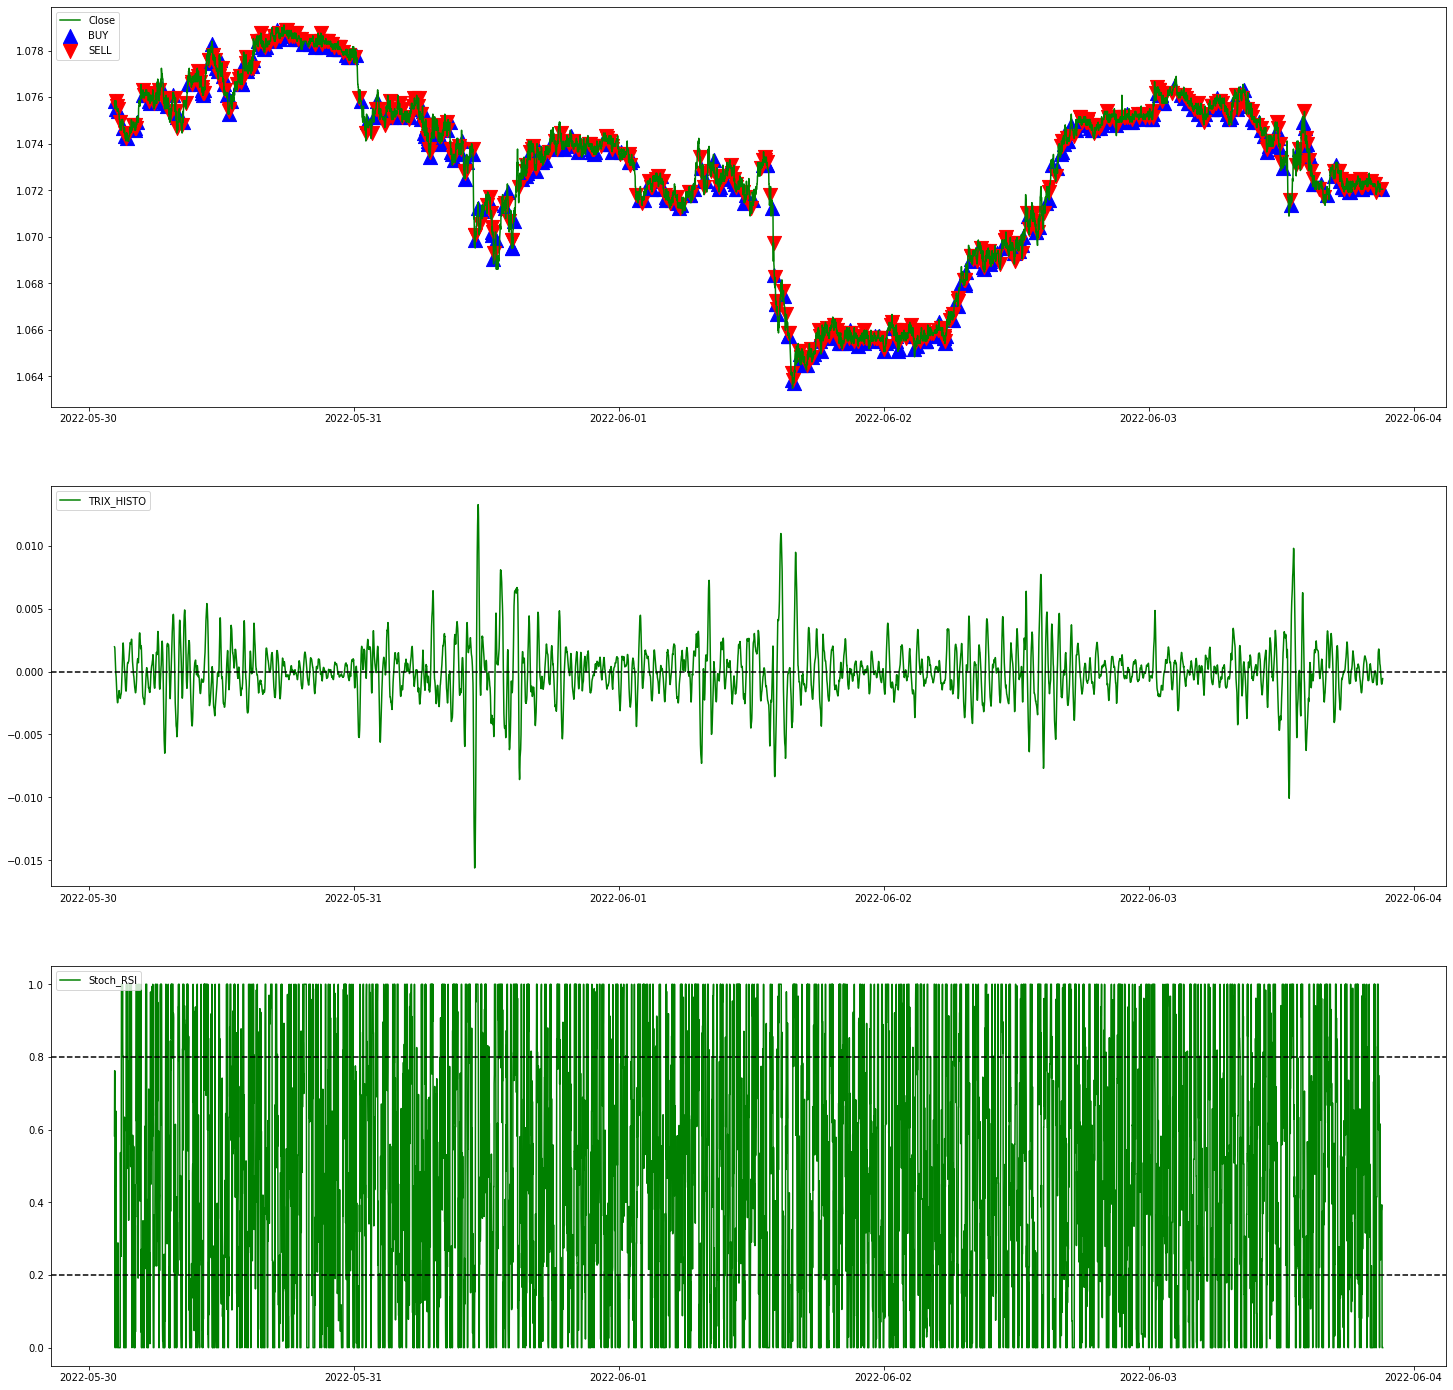

In [116]:
fig, ax_left = plt.subplots(3, figsize=(25,25))

ax_left[0].plot(df.Close, color='green',label='Close')
ax_left[0].scatter(df[df['BUY_SELL']=='BUY'].index, df[df['BUY_SELL']=='BUY'].Close, color='blue',label='BUY',marker='^',s=200)
ax_left[0].scatter(df[df['BUY_SELL']=='SELL'].index, df[df['BUY_SELL']=='SELL'].Close, color='red',label='SELL',marker='v',s=200)
ax_left[0].legend(loc="upper left")

ax_left[1].plot(df.TRIX_HISTO, color='green',label='TRIX_HISTO')
ax_left[1].axhline(y=0, color='black', linestyle='--')
ax_left[1].legend(loc="upper left")

ax_left[2].plot(df.Stoch_RSI, color='green',label='Stoch_RSI')
ax_left[2].axhline(y=0.2, color='black', linestyle='--')
ax_left[2].axhline(y=0.8, color='black', linestyle='--')
ax_left[2].legend(loc="upper left")

# Results analysis

In [192]:
df_trades = pd.read_csv('./data/trade.csv')
df_trades = df_trades[df_trades['symbol']=='ETH']
print(df_trades.head())
df_trades['Change'] = df_trades.price.pct_change()*100
sells = df_trades[df_trades['side']=='SELL']
print(f"Gain : {df_trades[df_trades['side']=='SELL']['Change'].sum()} %")
print(f"Winrate : {100*sells[sells['Change']>0].Change.count()/len(sells)} %")

      comment    price  side strategy symbol                 timestamp
0    Just BUY  1754.96   BUY     Trix    ETH  2022-06-03T12:52:19.000Z
7   Just SELL  1747.91  SELL     Trix    ETH  2022-06-03T13:12:14.000Z
11   Just BUY  1760.81   BUY     Trix    ETH  2022-06-03T14:13:11.000Z
20  Just SELL  1754.81  SELL     Trix    ETH  2022-06-03T16:28:25.000Z
21   Just BUY  1751.45   BUY     Trix    ETH  2022-06-03T16:33:23.000Z
Gain : 7.110260880905251 %
Winrate : 64.61538461538461 %
